<a href="https://colab.research.google.com/github/Kvnhooman/AAI521_Computer_vision_Group-4/blob/Kevin_Dev/Final_Project_Kevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from collections import Counter


In [1]:
#import kagglehub
#https://www.vision.ee.ethz.ch/datasets_extra/food-101/
# Download latest version
#path = kagglehub.dataset_download("dansbecker/food-101")

#print("Path to dataset files:", path)

100%|██████████| 9.38G/9.38G [07:08<00:00, 23.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1


In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [17]:
!mkdir -p "/content/drive/MyDrive/AAI521-Final Project/data"
!cp -r "/root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101" \
      "/content/drive/MyDrive/AAI521-Final Project/data/food101"

In [25]:
!ls "/content/drive/MyDrive/AAI521-Final Project/data/food101/food-101/food-101/images" | head


apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [27]:
!ls "/content/drive/MyDrive/AAI521-Final Project/data/food101/food-101/food-101/images" | wc -l


101


In [30]:
root = pathlib.Path("/content/drive/MyDrive/AAI521-Final Project/data/food101/food-101/food-101")

images_dir = root / "images"
meta_dir   = root / "meta"

print(images_dir)
print(meta_dir)


/content/drive/MyDrive/AAI521-Final Project/data/food101/food-101/food-101/images
/content/drive/MyDrive/AAI521-Final Project/data/food101/food-101/food-101/meta


In [31]:
!ls "{meta_dir}"


classes.txt  labels.txt  test.json  test.txt  train.json  train.txt


In [40]:
sizes = []
sample_classes = class_names[:10]  #sample 10 classes

for cls in sample_classes:
    img_files = os.listdir(images_dir / cls)[:20]
    for img_name in img_files:
        img_path = images_dir / cls / img_name
        img = cv2.imread(str(img_path))
        if img is not None:
            sizes.append(img.shape[:2])  #(height, width)

sizes = np.array(sizes)
print("Min size:", sizes.min(axis=0))
print("Max size:", sizes.max(axis=0))
print("Mean size:", sizes.mean(axis=0))


Min size: [289 304]
Max size: [512 512]
Mean size: [474.46 490.81]


This shows our original dataset has inconsistent image sizes. Therefore, resizing to a fixed shape is necessary since our deep learning models require for the input to have uniform dimensions.

In [32]:
def read_list(p: pathlib.Path):
    with open(p, "r") as f:
        return [ln.strip() for ln in f if ln.strip()]

train_list = read_list(meta_dir / "train.txt")
test_list  = read_list(meta_dir / "test.txt")

class_names = sorted([p.name for p in images_dir.iterdir() if p.is_dir()])
class_to_idx = {c: i for i, c in enumerate(class_names)}

def to_path_and_label(stem: str):
    cls, base = stem.split("/", 1)                 # e.g., "apple_pie/1005649"
    return str(images_dir / cls / f"{base}.jpg"), class_to_idx[cls]

train_pairs = [to_path_and_label(s) for s in train_list]
test_pairs  = [to_path_and_label(s) for s in test_list]

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE
SEED       = 0


def decode_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)   # normalization for MobileNet
    return img, label


train_paths, train_labels = zip(*train_pairs)
test_paths,  test_labels  = zip(*test_pairs)

train_ds = (tf.data.Dataset
            .from_tensor_slices((list(train_paths), list(train_labels)))
            .shuffle(len(train_pairs), seed=SEED, reshuffle_each_iteration=True)
            .map(decode_resize, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset
           .from_tensor_slices((list(test_paths), list(test_labels)))
           .map(decode_resize, num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE))

xb, yb = next(iter(train_ds.take(1)))
print("Batch:", xb.shape, xb.dtype, "range≈[", float(tf.reduce_min(xb)), ",", float(tf.reduce_max(xb)), "]")
print("Classes:", len(class_names))

Batch: (32, 224, 224, 3) <dtype: 'float32'> range≈[ -1.0 , 1.0 ]
Classes: 101


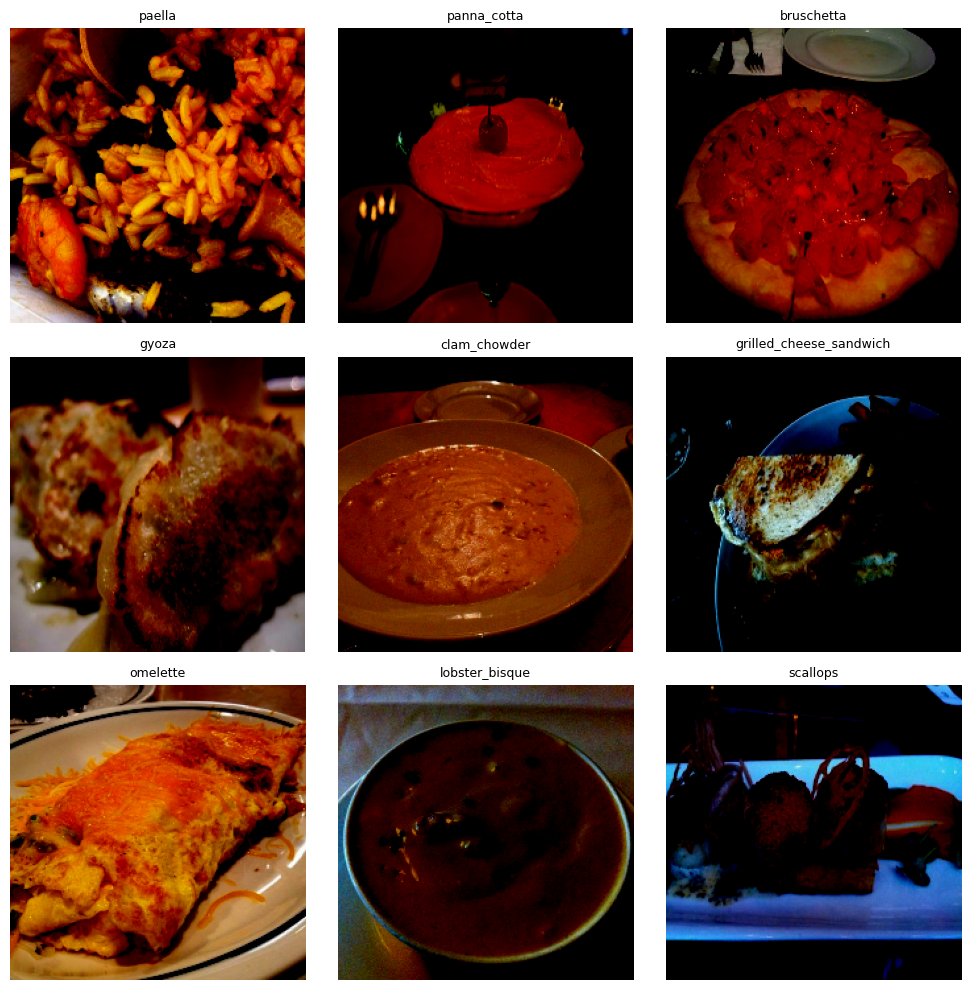

In [33]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels[i].numpy())], fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

In [36]:
#Augmentation Block
augment = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

#
train_ds = train_ds.map(lambda img, label: (augment(img, training=True), label))



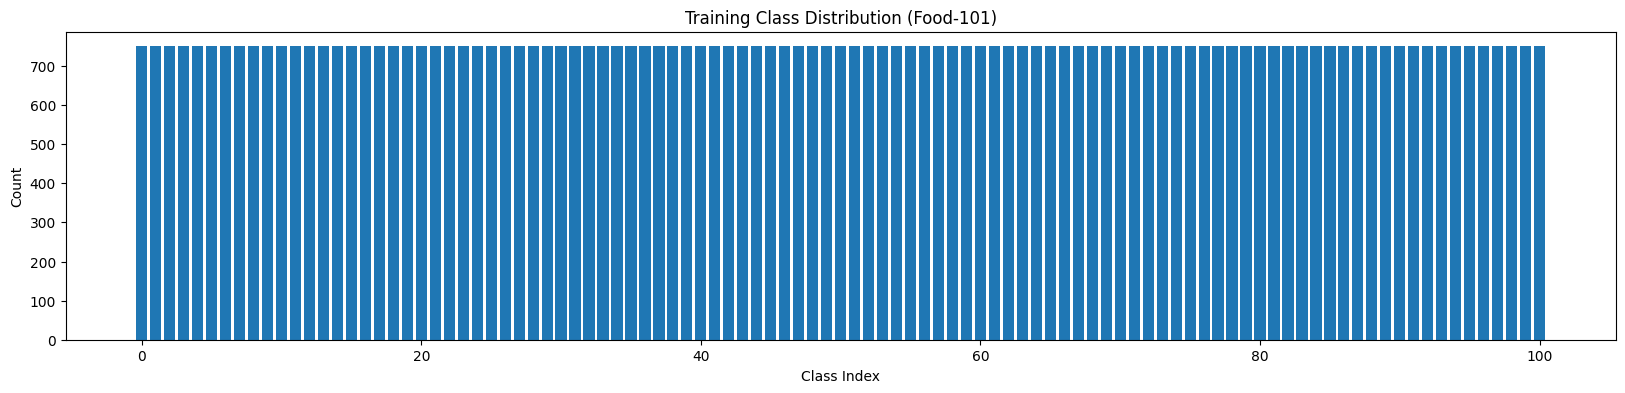

Total training samples: 75750
Total test samples: 25250
Number of classes: 101


In [37]:
# Check the data balance in the dataset
train_classes = [s.split("/")[0] for s in train_list]
train_counts = Counter(train_classes)

plt.figure(figsize=(20,4))
plt.bar(range(len(train_counts)), train_counts.values())
plt.title("Training Class Distribution (Food-101)")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

print("Total training samples:", len(train_list))
print("Total test samples:", len(test_list))
print("Number of classes:", len(class_names))


Data is well balanced among different classes.

In [39]:
print("Training examples:", len(train_list))
print("Testing examples:", len(test_list))
print("Classes:", len(class_names))
print("Image shape after preprocessing:", xb[0].shape)
print("Pixel range after preprocess_input(): [-1, 1]")


Training examples: 75750
Testing examples: 25250
Classes: 101
Image shape after preprocessing: (224, 224, 3)
Pixel range after preprocess_input(): [-1, 1]
